## Estimation Example



In this document we&rsquo;ll work through a simple approach to estimating
Constant Frisch Elasticity (CFE) demand systems.

There are two prerequisites; the first is the `CFEDemands` python
module.  You may have this already, but if not it  can be installed with a simple:



In [1]:
!pip install -r requirements.txt

  Using cached cfedemands-0.6.4.dev0-py2.py3-none-any.whl.metadata (1.6 kB)
  Using cached ConsumerDemands-0.4.3.dev0-py2.py3-none-any.whl.metadata (1.2 kB)
  Using cached eep153_tools-0.12.4-py2.py3-none-any.whl.metadata (363 bytes)
  Using cached python_gnupg-0.5.4-py2.py3-none-any.whl.metadata (2.0 kB)
  Using cached gspread_pandas-3.3.0-py2.py3-none-any.whl.metadata (10 kB)
  Using cached fsspec-2025.3.2-py3-none-any.whl.metadata (11 kB)
Using cached cfedemands-0.6.4.dev0-py2.py3-none-any.whl (45 kB)
Using cached ConsumerDemands-0.4.3.dev0-py2.py3-none-any.whl (12 kB)
Using cached eep153_tools-0.12.4-py2.py3-none-any.whl (4.9 kB)
Using cached python_gnupg-0.5.4-py2.py3-none-any.whl (21 kB)
Using cached gspread_pandas-3.3.0-py2.py3-none-any.whl (27 kB)
Using cached fsspec-2025.3.2-py3-none-any.whl (194 kB)
  Attempting uninstall: gspread_pandas
    Found existing installation: gspread-pandas 2.2.3
    Uninstalling gspread-pandas-2.2.3:
      Successfully uninstalled gspread-pandas-2

The second prerequisite is a dataset including detailed information on
household expenditures and characteristics.  The structure of that
dataset is detailed in the next section.



### Data



Consider the case in which the data are saved in a google sheet; we&rsquo;ll
turn data from these into `pandas` dataframes.
There are limits on the allowable size of google sheets (5 million
cells when I last checked), so if your dataset is larger than this you&rsquo;ll need some other
mechanism to get your data into such dataframes.  Even in this latter
case you&rsquo;ll want your dataframes to have a structure that matches the
description given below.



#### Structure of the Spreadsheet



An example spreadsheet with data for Uganda can be found at
[https://docs.google.com/spreadsheets/d/1yFWlP5N7Aowaj6t2roRSFFUC50aFD-RLBGfzGtqLl0w/](https://docs.google.com/spreadsheets/d/1yFWlP5N7Aowaj6t2roRSFFUC50aFD-RLBGfzGtqLl0w/)

This spreadsheet consists of several worksheets, labeled &ldquo;RDI&rdquo;, &ldquo;FCT&rdquo;,
&ldquo;Household Characteristics&rdquo;, and a series of different years of food expenditures and prices

Most worksheets have the initial three columns labeled &ldquo;i&rdquo;, &ldquo;t&rdquo;, and
&ldquo;m&rdquo;; together these identify an observation uniquely.  The column &ldquo;i&rdquo;
should include a household id; the column &ldquo;t&rdquo; should include an
indicator for the year or period (for those of you with
cross-sectional data these will all take a common value, e.g., 2019);
the column &ldquo;m&rdquo; should be an indicator of &ldquo;market&rdquo;, which may be a
region identifier, or may take a single value (e.g., &ldquo;Uganda&rdquo;).

The triple (i,t,m) will serve as the index of some constructed
dataframes.  It is important not to have **too** many different values
for &ldquo;m&rdquo; (unless you have lots of data and RAM to play with).

Beyond the first three columns, the &ldquo;Expenditures&rdquo; worksheet for a given year should have one index (or alternatively, one column) for each category of expenditures (e.g., &ldquo;Beans&rdquo;, &ldquo;Beef&rdquo;, &ldquo;Beer&rdquo;,&#x2026;).

Beyond the first three columns, the &ldquo;Household Characteristics&rdquo; should
have columns corresponding to different elements of the vector of
observable characteristics $z$.  If the data permit, I recommend
constructing observables that match what I have in these data:
namely numbers of different children by age and sex, along with the
logarithm of total household size (&ldquo;log HSize&rdquo;).



#### From Sheet to DataFrame to Regression Object



We begin by defining a dictionary that contains the spreadsheet key.
One is provided for the Ugandan example that I wish to work
through.



In [21]:
Uganda_Data = '1yFWlP5N7Aowaj6t2roRSFFUC50aFD-RLBGfzGtqLl0w'
US_Data = "1OWluIYUGkmR6iFgSzJJa2ikEqqMT6BHbsKZyip236HU"

With the spreadsheet defined , grab it and define a couple of
dataframes. (Sheets should be shared with `students@eep153.iam.gserviceaccount.com`):



In [48]:
import pandas as pd
import numpy as np
from eep153_tools.sheets import read_sheets

# Change 'Uganda_Data' to key of your own sheet in Sheets, above
x = read_sheets(US_Data,sheet='Food Expenditures 2021')
x.drop("food_name", axis=1, inplace=True)
x = x.set_index(['i','t','m','j']).squeeze()


# Now prices
#p = read_sheets(Uganda_Data,sheet='Food Prices (2019-20)').set_index(['t','m','j','u'])

# Compute medians of prices for particular time, place and unit
#p = p.groupby(['t','m','j','u']).median()

# Just keep metric units
#p = p.xs('Kg',level="u").squeeze().unstack('j')

# Drop prices for goods we don't have expenditures for
#p = p[x.index.levels[-1]].T

# Household characteristics
d = read_sheets(US_Data,sheet="Household Characteristics 2021")
d.columns.name = 'k'
d["sex"] = d["sex"].map({"Female": 1, "Male": 0})
d['log_household'] = np.log(d['HH_size'])
d.drop("HH_size", axis= 1, inplace=True)

# Fill blanks with zeros
d = d.replace(np.nan,0)

# Expenditures x may have duplicate columns
x = x.T.groupby(['i','t','m','j']).sum()
x = x.replace(0,np.nan) # Replace zeros with missing

# Take logs of expenditures; call this y
y = np.log(x)
d.set_index(['i','t','m'],inplace=True)

This gives a dataframe of household characteristics $d$ with a simple structure.



In [49]:
x.shape

(141104,)

Also a dataframe of log expenditures $y$ with a similarly simple
structure.  Note that any expenditures of zero are dropped and
replaced with a missing value indicator.



In [50]:
y.head()

i       t     m    j       
130378  2021  USA  13110102    4.828314
                   14108010    0.732368
                   24100000    5.136386
                   24100020    5.136386
                   26137123    5.136386
Name: grams, dtype: float64

### Estimation



Let $y_{i}^j$ be log expenditures on food $j$ by household $i$ at a particular time.  We want to estimate a regression that takes the form
$$
      y^j_{i} = A^j(p) + \gamma_j'd_i + \beta_j w_i + \zeta^j_i.
$$
We have data on `y` (log expenditures) and `d` (household characteristics).  This leaves the rest of the elements for us to estimate.



#### Basic Estimation



Just one line to set up the regression:



In [51]:
y

i       t     m    j       
130378  2021  USA  13110102    4.828314
                   14108010    0.732368
                   24100000    5.136386
                   24100020    5.136386
                   26137123    5.136386
                                 ...   
142310  2021  USA  92101000    6.173786
                   93301110    5.886104
                   93401010    0.631272
                   93505000    4.430817
                   94100100    6.201523
Name: grams, Length: 141104, dtype: float64

In [52]:
d

,,k,age,sex,log_household
i,t,m,,,
130378,2021,USA,43.0,0,1.386294
130379,2021,USA,66.0,0,0.693147
130380,2021,USA,44.0,1,1.945910
130381,2021,USA,5.0,1,0.693147
130382,2021,USA,2.0,0,1.386294
...,...,...,...,...,...
142306,2021,USA,9.0,0,0.693147
142307,2021,USA,49.0,1,1.609438
142308,2021,USA,50.0,0,1.098612


In [53]:
Regression?

Init signature:
Regression(
    correct_miss=False,
    method='linear',
    K=None,
    bootstrap_tol=None,
    compute_se=False,
    rectify=False,
    verbose=False,
    min_obs=30,
    min_prop_items=0.1,
    alltm=True,
    **kwargs,
)
Docstring:     
A class which packages together data and methods for estimating a CFE demand system posed as a regression.

Data elements (and outputs) are typically pandas Series or DataFrames.  Indexes are kept consistent across objects, with:
   - i :: Indexes households
   - t :: Indexes periods
   - m :: Indexes markets
   - j :: Indexes goods
   - k :: Indexes household characteristics

Ethan Ligon                               October 2022
Init docstring:
To load data, use cfe.read_sql() or cfe.read_pickle().

To instantiate from data on log expenditures (y) and household
characteristics (d), supply each as pd.DataFrames, with indices for y
(i,t,m) and columns (j,) and for d indices (i,t,m) and columns (k,).
File:           /srv/conda/lib/pyt

In [54]:
from cfe import Regression

result = Regression(y=y,d=d,min_prop_items=0.002)

And then one line to predict expenditures and estimate most of the things we need:



In [ ]:
result.predicted_expenditures()

Now we can compare predicted log expenditures with actual:



In [ ]:
%matplotlib inline
df = pd.DataFrame({'y':y,'yhat':result.get_predicted_log_expenditures()})
df.plot.scatter(x='yhat',y='y')

That&rsquo;s all there is to estimation!  Note that we didn&rsquo;t estimate
demands for all goods&#x2014;lots of goods didn&rsquo;t have enough observations,
and were automatically dropped.



#### Parameters



##### (Relative) Income Elasticity



Some of the parameters have an interesting interpretation.  First among these are the $\beta$ coefficients, which govern how *income elastic* different goods are (higher values means more elastic).  These are also called *Frisch elasticities*.
Here we use a plot to visualize, with confidence intervals.



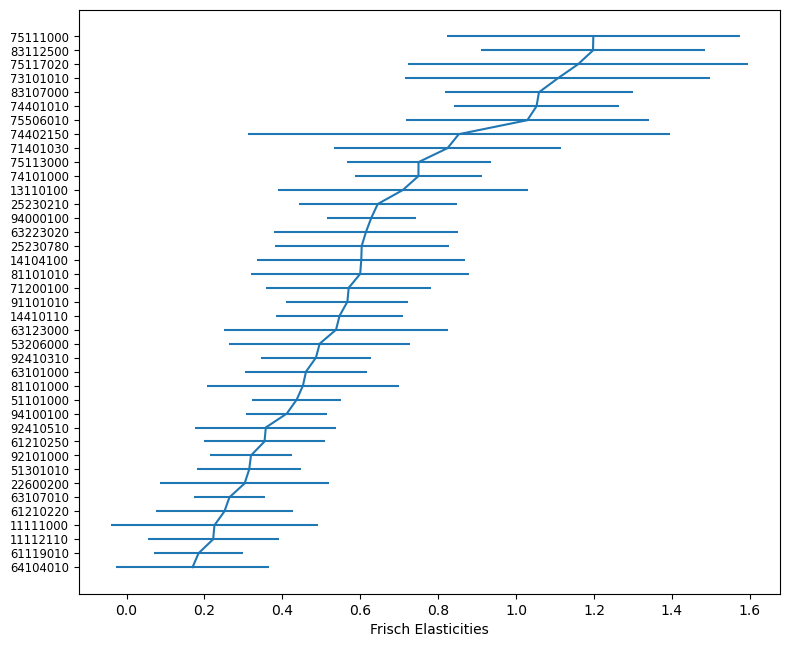

In [43]:
ax = result.graph_beta()

To just see the values of $\beta$:



In [44]:
result.get_beta()

j
11111000    0.225610
11112110    0.222357
13110100    0.709071
14104100    0.602514
14410110    0.546781
22600200    0.303078
25230210    0.644753
25230780    0.603621
51101000    0.436855
51301010    0.314819
53206000    0.495742
61119010    0.184871
61210220    0.251309
61210250    0.354211
63101000    0.460604
63107010    0.264051
63123000    0.537717
63223020    0.614552
64104010    0.169471
71200100    0.570264
71401030    0.823966
73101010    1.106986
74101000    0.749225
74401010    1.052351
74402150    0.852795
75111000    1.198141
75113000    0.749467
75117020    1.158670
75506010    1.028730
81101000    0.452811
81101010    0.599762
83107000    1.058531
83112500    1.197268
91101010    0.566830
92101000    0.319400
92410310    0.486100
92410510    0.357506
94000100    0.628069
94100100    0.411461
Name: beta, dtype: float64

##### Demand and Household Composition



We&rsquo;re particularly interested in the effects of household composition on demand.  These are captured by the $\gamma_j$ parameters in the regression.



In [11]:
result.get_gamma()

k,Females 00-03,Females 04-08,Females 09-13,Females 14-18,Females 19-30,Females 31-50,Females 51-99,Males 00-03,Males 04-08,Males 09-13,Males 14-18,Males 19-30,Males 31-50,Males 51-99,log HSize,Constant
j,,,,,,,,,,,,,,,,
Avocado,-0.075130,-0.096756,0.084182,-0.020909,-0.067245,0.052538,0.142329,-0.009031,-0.102307,-0.004225,-0.023604,-0.048174,0.184218,0.141886,0.359116,7.295330
Beans (dry),-0.119205,-0.011679,0.016457,-0.032303,-0.006493,0.021725,0.090761,-0.078460,0.013432,0.025968,0.045490,0.060823,0.002167,0.093750,0.509117,8.344383
Beans (fresh),-0.135883,-0.009350,0.182532,0.058728,-0.052626,0.059083,0.056270,0.040204,-0.064929,0.073651,-0.046357,-0.089039,-0.129506,0.070576,0.435945,8.290561
Beef,-0.124955,0.030874,0.036872,0.011101,0.085192,0.105158,0.231804,-0.006167,0.042996,0.026783,0.041476,0.078713,0.199303,0.158738,0.115244,9.278204
Bogoya,-0.079815,-0.111142,0.036841,-0.175985,0.118642,0.108468,0.245149,0.145858,0.037278,0.059983,-0.009456,0.007480,0.014867,0.220527,0.420928,7.730244
Bread,-0.013796,0.037677,-0.042708,0.025537,0.042576,0.070712,0.116402,-0.048262,0.068566,0.029174,0.024188,0.060000,0.182989,0.114190,0.198986,8.298821
Cabbage (green),-0.007169,-0.056088,0.045229,0.028790,-0.012902,0.040766,0.054226,-0.035323,0.011107,0.022596,0.046213,0.081324,0.020000,0.039899,0.203232,7.049881
Cassava (dry),-0.037626,0.004953,-0.000825,0.037702,-0.017457,0.095118,0.100100,0.010373,0.054489,0.178974,0.192838,0.067130,-0.024498,0.038514,0.309090,8.375994
Cassava (fresh),0.027196,0.065150,0.128347,0.003786,0.029914,0.018645,0.163190,-0.000794,0.116971,0.139972,0.128480,0.030488,0.004316,0.094468,0.206271,8.142775


##### Welfare



Another import quantity we estimate is $w_i$.  This is a welfare measure for the household.  Here&rsquo;s a histogram:



<Axes: ylabel='Density'>

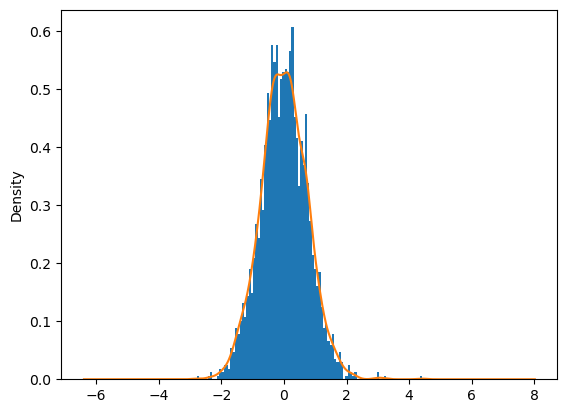

In [12]:
ax = result.get_w().plot.hist(bins=100,density=True)
result.get_w().plot.kde(ax=ax)

#### Saving Result



You can save the estimated result, using something like



In [13]:
result.to_pickle('uganda_estimates.rgsn')

You can subsequently load this using



In [14]:
import cfe
result = cfe.regression.read_pickle('uganda_estimates.rgsn')

#### Demand and Utility



Having estimated the demand system, we can examine the implied demand curves.



##### Budgets



Get food budget for all households, then find median budget:



In [15]:
import numpy as np

xhat = result.predicted_expenditures()

# Total food expenditures per household
xbar = xhat.groupby(['i','t','m']).sum()

# Reference budget
xref = xbar.quantile(0.5)  # Household at 0.5 quantile is median

##### Reference Prices



Choose reference prices.  Here we&rsquo;ll choose a particular year, and average prices across markets.  If you wanted to focus on particular market you&rsquo;d do this differently.



In [16]:
# Reference prices chosen from a particular time; average across place.
# These are prices per kilogram:
pbar = p.mean(axis=1)
pbar = pbar[result.beta.index] # Only use prices for goods we can estimate

# Replace missing prices with 1 (this is because they're best measured in expenditures)
pbar = pbar.replace(np.nan,1)

#Finally, define a function to change a single price in the vector $p$:
def my_prices(p0,j,p=pbar):
    """
    Change price of jth good to p0, holding other prices fixed.
    """
    p = p.copy()
    p.loc[j] = p0
    return p

##### Demand as a function of prices



Let&rsquo;s take a look at demand schedules for households with different budgets.



Text(0.5, 0, 'Quantities of Millet Flour Demanded')

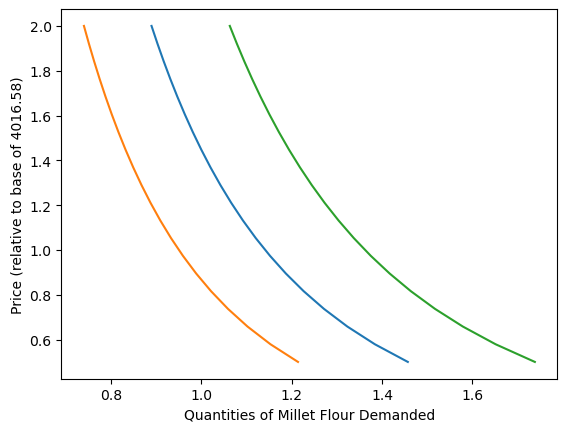

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

use = 'Millet Flour'  # Good we want demand curve for

# Vary prices from 50% to 200% of reference.
scale = np.linspace(.5,2,20)

# Demand for Millet for household at median budget
plt.plot([result.demands(xref,my_prices(pbar[use]*s,use,pbar))[use] for s in scale],scale)

# Demand for Millet for household at 25% percentile
plt.plot([result.demands(xbar.quantile(0.25),my_prices(pbar[use]*s,use,pbar))[use] for s in scale],scale)

# Demand for Millet for household at 75% percentile
plt.plot([result.demands(xbar.quantile(0.75),my_prices(pbar[use]*s,use,pbar))[use] for s in scale],scale)

plt.ylabel(f"Price (relative to base of {pbar[use]:.2f})")
plt.xlabel(f"Quantities of {use} Demanded")

##### Engel Curves



Engel curves trace out how demand changes with budget:



Text(0.5, 1.0, 'Engel Curves')

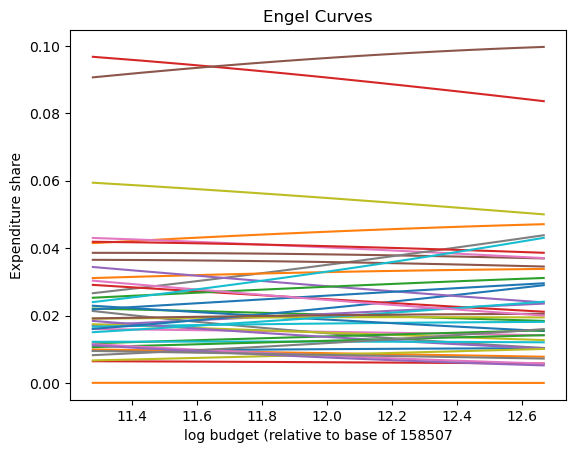

In [18]:
fig,ax = plt.subplots()

ax.plot(np.log(scale*xref),[result.expenditures(s*xref,pbar)/(s*xref) for s in scale])
ax.set_xlabel(f'log budget (relative to base of {xref:.0f}')
ax.set_ylabel(f'Expenditure share')
ax.set_title('Engel Curves')

##### Indirect Utility



We can also describe an indirect utility function that corresponds to these demands:



Text(0.5, 1.0, 'Indirect Utility Function')

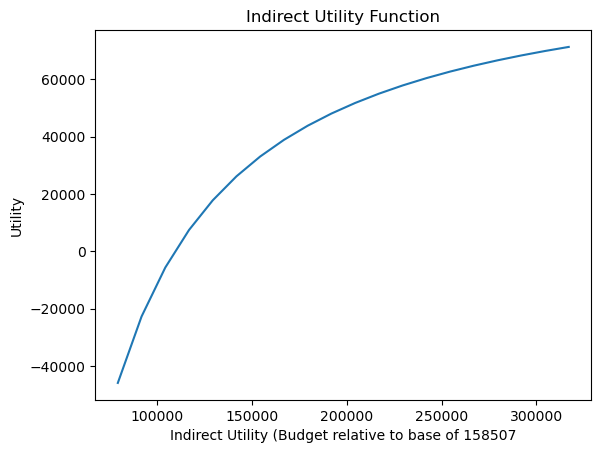

In [19]:
fig,ax = plt.subplots()

ax.plot(scale*xref,[result.indirect_utility(s*xref,pbar) for s in scale])
ax.set_xlabel(f'Indirect Utility (Budget relative to base of {xref:.0f}')
ax.set_ylabel(f'Utility')
ax.set_title('Indirect Utility Function')